# Process Effectiveness Data

Data from [GitHub](https://github.com/gtvalab/ChartsEffectiveness/tree/master/Raw-Data).

In [1]:
import pandas as pd
import itertools
import scipy.stats as stats
import json
import numpy as np
from draco.learn.helper import contingency_table
from draco.spec import Task, Field, Data
from copy import copy
from collections import defaultdict
import networkx as nx

In [2]:
df_orig = pd.read_csv('OverallData.csv')

# fix typo
df_orig.visualization.replace({'Scatterplot': 'ScatterPlot'}, inplace=True)

In [3]:
# Remove pie charts and tables
df = df_orig
df = df[df.visualization != 'PieChart']
df = df[df.visualization != 'Table']

In [4]:
np.unique(df.task)

array(['Anomalies', 'Cluster', 'Correlation', 'Derived', 'Distribution',
       'Extremum', 'Filter', 'Order', 'Range', 'Retrieve'], dtype=object)

In [5]:
# rename tasks into our taxonomy
df.task.replace({
    'Extremum': 'summary',
    'Range': 'summary',
    'Derived': 'summary',
    'Anomalies': 'summary',
    'Cluster': 'summary',
    'Correlation': 'summary',
    'Distribution': 'summary',
    
    'Retrieve': 'value',
    'Filter': 'value',
    'Order': 'value'
}, inplace=True)

# drop other tasks
# df = df[df.task != 'Anomalies']

In [6]:
np.unique(df.task)

array(['summary', 'value'], dtype=object)

In [7]:
df

,task,x,y,dataset,visualization,accuracy,rank,time
0,summary,Nominal,Numerical,CarData,BarChart,100,1,6
1,summary,Nominal,Numerical,CarData,BarChart,100,1,6
2,summary,Nominal,Numerical,CarData,BarChart,100,3,5
3,summary,Nominal,Numerical,CarData,BarChart,100,3,4
4,summary,Nominal,Numerical,CarData,BarChart,100,2,1
5,summary,Nominal,Numerical,CarData,BarChart,0,2,6
6,summary,Nominal,Numerical,CarData,BarChart,100,1,8
7,summary,Nominal,Numerical,CarData,BarChart,100,2,6
8,summary,Nominal,Numerical,CarData,BarChart,0,4,6
9,summary,Nominal,Numerical,CarData,BarChart,100,1,8


In [8]:
gb = df.groupby(['visualization'])
gb.describe()

accuracy                                                         \
                 count       mean        std  min    25%    50%    75%    max   
visualization                                                                   
BarChart        1044.0  88.409962  32.025884  0.0  100.0  100.0  100.0  100.0   
LineChart       1044.0  77.011494  42.096040  0.0  100.0  100.0  100.0  100.0   
ScatterPlot     1044.0  84.195402  36.495894  0.0  100.0  100.0  100.0  100.0   

                 rank            ...                time             \
                count      mean  ...    75%  max   count       mean   
visualization                    ...                                  
BarChart       1044.0  2.223180  ...    3.0  5.0  1044.0  17.055556   
LineChart      1044.0  3.676245  ...    5.0  5.0  1044.0  20.362069   
ScatterPlot    1044.0  3.475096  ...    4.0  5.0  1044.0  19.159962   

                                                        
                     std  min   25%   50%   75%    max  
visualization                                           
BarChart       12.748199  1.0   9.0  14.0  22.0  151.0  
LineChart      18.059695  1.0  10.0  15.0  24.0  206.0  
ScatterPlot    16.594143  1.0   9.0  15.0  23.0  170.0  

[3 rows x 24 columns]

In [9]:
gb = df.groupby(['visualization', 'task', 'x', 'y', 'dataset'])

In [10]:
gb.describe()

accuracy             \
                                                       count       mean   
visualization task    x         y         dataset                         
BarChart      summary Nominal   Numerical CarData      108.0  88.888889   
                                          MovieData    108.0  84.259259   
                      Numerical Numerical CarData      126.0  85.714286   
                                          MovieData    126.0  80.952381   
                      Ordinal   Numerical CarData      126.0  87.301587   
                                          MovieData    126.0  92.063492   
              value   Nominal   Numerical CarData       58.0  94.827586   
                                          MovieData     50.0  90.000000   
                      Numerical Numerical CarData       58.0  91.379310   
                                          MovieData     50.0  92.000000   
                      Ordinal   Numerical CarData       58.0  94.827586   
                                          MovieData     50.0  92.000000   
LineChart     summary Nominal   Numerical CarData      108.0  94.444444   
                                          MovieData    108.0  87.037037   
                      Numerical Numerical CarData      126.0  57.142857   
                                          MovieData    126.0  63.492063   
                      Ordinal   Numerical CarData      126.0  75.396825   
                                          MovieData    126.0  76.984127   
              value   Nominal   Numerical CarData       58.0  86.206897   
                                          MovieData     50.0  92.000000   
                      Numerical Numerical CarData       58.0  65.517241   
                                          MovieData     50.0  62.000000   
                      Ordinal   Numerical CarData       58.0  89.655172   
                                          MovieData     50.0  94.000000   
ScatterPlot   summary Nominal   Numerical CarData      108.0  87.962963   
                                          MovieData    108.0  88.888889   
                      Numerical Numerical CarData      126.0  76.190476   
                                          MovieData    126.0  72.222222   
                      Ordinal   Numerical CarData      126.0  87.301587   
                                          MovieData    126.0  88.095238   
              value   Nominal   Numerical CarData       58.0  98.275862   
                                          MovieData     50.0  96.000000   
                      Numerical Numerical CarData       58.0  84.482759   
                                          MovieData     50.0  68.000000   
                      Ordinal   Numerical CarData       58.0  89.655172   
                                          MovieData     50.0  80.000000   

                                                                            \
                                                           std  min    25%   
visualization task    x         y         dataset                            
BarChart      summary Nominal   Numerical CarData    31.573482  0.0  100.0   
                                          MovieData  36.588229  0.0  100.0   
                      Numerical Numerical CarData    35.132403  0.0  100.0   
                                          MovieData  39.424430  0.0  100.0   
                      Ordinal   Numerical CarData    33.428436  0.0  100.0   
                                          MovieData  27.138680  0.0  100.0   
              value   Nominal   Numerical CarData    22.340380  0.0  100.0   
                                          MovieData  30.304576  0.0  100.0   
                      Numerical Numerical CarData    28.312063  0.0  100.0   
                                          MovieData  27.404752  0.0  100.0   
                      Ordinal   Numerical CarData    22.340380  0.0  100.0   
                                  

In [11]:
# trying to make sense of x and y
df.groupby(['x', 'y']).describe()

accuracy                                                  \
                       count       mean        std  min    25%    50%    75%   
x         y                                                                    
Nominal   Numerical    972.0  90.020576  29.987975  0.0  100.0  100.0  100.0   
Numerical Numerical   1080.0  74.074074  43.843116  0.0    0.0  100.0  100.0   
Ordinal   Numerical   1080.0  86.203704  34.502088  0.0  100.0  100.0  100.0   

                              rank            ...                time  \
                       max   count      mean  ...    75%  max   count   
x         y                                   ...                       
Nominal   Numerical  100.0   972.0  3.211934  ...    4.0  5.0   972.0   
Numerical Numerical  100.0  1080.0  3.082407  ...    4.0  5.0  1080.0   
Ordinal   Numerical  100.0  1080.0  3.088889  ...    4.0  5.0  1080.0   

                                                                         
                          mean        std  min   25%   50%   75%    max  
x         y                                                              
Nominal   Numerical  18.682099  15.441820  1.0  10.0  15.0  23.0  203.0  
Numerical Numerical  20.835185  16.602217  1.0  10.0  16.0  26.0  153.0  
Ordinal   Numerical  17.042593  15.700571  1.0   8.0  13.0  21.0  206.0  

[3 rows x 24 columns]

In [12]:
def parse(group):
    task = group['task'].iloc[0]
    x = group['x'].iloc[0]
    
    dataset = group['dataset'].iloc[0]
    
    num_rows = 407 if dataset == 'CarData' else 335 # between sizes of movie and cars data
    
    fields = [
        {'name': 'n', 'type': 'string', 'cardinality': 9},  # 6 or 12
        {'name': 'q1', 'type': 'number', 'cardinality': 25},  # between 5 and 50, depending on attribute
        {'name': 'q2', 'type': 'number', 'cardinality': num_rows},
    ]
    
    # we only specify interestingness if not both x and y are interesting
    
    # tasks: 'compare', 'derived', 'extremum', 'value'
    
    x_tasks = []  # ['Distribution', 'Cluster']
    y_tasks = []  # ['Extremum', 'Retrieve']
    
    if task in x_tasks:
        # mostly x is interesting
        if x == 'Numerical':
            fields[1]['interesting'] = True
        else:  # Ordinal or Nominal
            fields[0]['interesting'] = True
    elif task in y_tasks:
        # mostly y is interesting
        fields[2]['interesting'] = True

    enc = {}
    
    t = group['visualization'].iloc[0]
    if t == 'BarChart':
        mark = 'bar'
    elif t == 'LineChart':
        mark = 'line'
    elif t == 'ScatterPlot':
        mark = 'point'
    
    if x == 'Numerical':
        # only scatterplots and lines can really be qq
        enc['x'] = {'field': 'q1', 'type': 'quantitative' if t != 'BarChart' else 'ordinal'}
    elif x == 'Nominal':
        enc['x'] = {'field': 'n', 'type': 'nominal'}
    else:  # x is Ordinal
        enc['x'] = {'field': 'n', 'type': 'ordinal'}

    # y is always numerical and always aggregated
    enc['y'] = {'field': 'q2', 'type': 'quantitative', 'aggregate': 'mean', 'scale': {'zero': True}}
        
    spec = {
        'mark': mark,
        'encoding': enc
    }
    
    return {
        'x': x,
        'fields': fields,
        'task': task,
        'spec': spec,
        'num_rows': num_rows,
        'visualization': group['visualization'].iloc[0],
        'isCorrect': list(map(lambda x: True if x == 100 else False, group['accuracy'])),
        'completionTime': group['time']
    }

In [13]:
specs = pd.DataFrame(columns=['x', 'fields', 'task', 'spec', 'num_rows', 'visualization',
                              'isCorrect', 'completionTime'])
for name, group in gb:
    parsed = parse(group)
    specs = specs.append(parsed, ignore_index=True)
    
print('Number of groups', len(specs))

Number of groups 36


In [14]:
grouped_specs = specs.groupby(['task', 'x', 'num_rows'])

print(len(grouped_specs))

12


In [15]:
grouped_specs.visualization.describe()

count unique       top freq
task    x         num_rows                            
summary Nominal   335          3      3  BarChart    1
                  407          3      3  BarChart    1
        Numerical 335          3      3  BarChart    1
                  407          3      3  BarChart    1
        Ordinal   335          3      3  BarChart    1
                  407          3      3  BarChart    1
value   Nominal   335          3      3  BarChart    1
                  407          3      3  BarChart    1
        Numerical 335          3      3  BarChart    1
                  407          3      3  BarChart    1
        Ordinal   335          3      3  BarChart    1
                  407          3      3  BarChart    1

In [17]:
training = []

for name, group in grouped_specs:
    for fst, snd in itertools.combinations(range(len(group)), 2):
        first = group.iloc[fst]
        second = group.iloc[snd]
        
        significant = 'accuracy'
        
        # Run Fisher's test with unpaired data
        # https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.fisher_exact.html
        ct = contingency_table(first.isCorrect, second.isCorrect)
        oddsratio, p = stats.fisher_exact(ct)
        
        if p > .01:
            # run Welch's t-test: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_ind.html
            t, p = stats.ttest_ind(first.completionTime, second.completionTime, equal_var=False)
            significant = 'completion'
        
        if p <= .01:
            
            # sort first by accuracy, then time
            mf = np.mean(first.isCorrect)
            ms = np.mean(second.isCorrect)
            first_better = mf > ms if mf != ms else np.mean(first.completionTime) > np.mean(second.completionTime)
        
            training.append({
                'num_rows': int(group.iloc[0]['num_rows']),
                'significant': significant,
                'fields': group.iloc[0]['fields'],
                'task': group.iloc[0]['task'],
                'negative': second.spec if first_better else first.spec,
                'positive': first.spec if first_better else second.spec,
                'pvalue': round(p, 6)
            })

In [18]:
len(training)

10

In [19]:
with open('../data/training/saket2018.json', 'w') as f:
    json.dump({'$schema': './schema.json', 'source': 'saket2018', 'data': training}, f, indent=2)

In [20]:
order = defaultdict(lambda: defaultdict(nx.DiGraph))

per_task = defaultdict(nx.DiGraph)

for name, group in grouped_specs:
    for fst, snd in itertools.combinations(range(len(group)), 2):
        first = group.iloc[fst]
        second = group.iloc[snd]
        
        ct = contingency_table(first.isCorrect, second.isCorrect)        
        oddsratio, p = stats.fisher_exact(ct)
        
        task = group.iloc[0]['task']
        x = group.iloc[0]["x"]
        data_key = f'{x}_{group.iloc[0]["num_rows"]}'
        
        g = order[task][data_key]
        
        g.add_node(first.spec['mark'])
        g.add_node(second.spec['mark'])
        
        if p <= .01:
            first_better = np.mean(first.isCorrect) > np.mean(second.isCorrect)

            negative = second.spec if first_better else first.spec
            positive = first.spec if first_better else second.spec
                    
            g.add_edge(negative['mark'], positive['mark'])

In [21]:
# find optimal specs

data_keys = order['value'].keys()

perfects_bh = defaultdict(lambda: defaultdict(set))

for task in ['value', 'summary']:
    for data_key in data_keys:
        G = order[task][data_key]
        nodes = G.nodes
        edges = G.out_edges
        imperfect_nodes = set(map(lambda e: e[0], edges))
        perfects_bh[task][data_key] = set(nodes) - imperfect_nodes
        
perfects_bh = dict(perfects_bh)
%store perfects_bh  # store so we can load it later

Stored 'perfects_bh' (dict)


In [22]:
specs = []

for pair in training:
    negative = copy(pair['negative'])
    positive = copy(pair['positive'])
    
    fields = list(map(Field.from_obj, pair['fields']))
    data = Data(fields, pair.get('num_rows'))
        
    data.fill_with_random_content()
    vals = data.content
    
    negative['data'] = {
        'values': vals
    }
    positive['data'] = {
        'values': vals
    }
    
    specs.append({
        'first': negative,
        'second': positive,
        'properties': {
            'task': pair['task'],
            'pvalue': pair['pvalue'],
            'num_rows': pair['num_rows'],
            'significant': pair['significant']
        }
    })

with open('../data/spec_pairs/saket2018.json', 'w') as f:
    json.dump({
        "headers": {
            "first": {
                "title": "Negative",
                "subtitle": "worse accuracy"
            },
            "second": {
                "title": "Positive",
                "subtitle": "better accuracy"
            }
        },
        "specs": specs
    }, f, indent=2)

## Experiment with tasks to figure out what tasks are actually different

In [30]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [24]:
tasks = df_orig.drop(['rank'], axis=1).groupby(['task', 'visualization']).agg(['mean'])  # ,'std'
X = tasks.unstack()
X

accuracy                                               \
                    mean                                                
visualization   BarChart  LineChart   PieChart ScatterPlot      Table   
task                                                                    
Anomalies      75.000000  69.444444  69.444444   83.333333  68.518519   
Cluster        96.296296  58.333333  97.222222   75.925926  85.185185   
Correlation    80.555556  88.888889  66.666667   86.111111  52.777778   
Derived        90.740741  66.666667  89.814815   82.407407  93.518519   
Distribution   77.777778  70.370370  66.666667   75.000000  66.666667   
Extremum       94.444444  92.592593  93.611111   94.444444  93.518519   
Filter         91.666667  88.888889  92.592593   87.962963  93.518519   
Order          89.814815  75.925926  85.185185   82.407407  82.407407   
Range          88.888889  83.333333  87.962963   86.111111  83.333333   
Retrieve       96.296296  79.629630  92.592593   88.888889  96.296296   

                    time                                               
                    mean                                               
visualization   BarChart  LineChart   PieChart ScatterPlot      Table  
task                                                                   
Anomalies      10.351852  14.518519  19.398148   13.870370  17.129630  
Cluster        14.342593  20.000000  12.750000   16.907407  17.722222  
Correlation     9.805556   7.666667  20.416667    9.666667  18.569444  
Derived        20.833333  24.185185  18.462963   22.601852  16.129630  
Distribution   23.555556  26.759259  27.138889   21.425926  29.037037  
Extremum       12.138889  14.527778  17.712963   14.064815  17.537037  
Filter         18.787037  32.074074  30.203704   29.879630  20.231481  
Order          21.842593  26.037037  33.768519   28.611111  30.342593  
Range          24.435185  18.546296  19.601852   17.592593  22.314815  
Retrieve       12.046296  15.074074  10.722222   13.814815   9.425926

In [25]:
task_names = np.array(X.index)

In [26]:
model = KMeans(n_clusters=4)
# model = SpectralClustering(n_clusters=4)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
model.labels_

array([2, 0, 2, 0, 2, 3, 1, 1, 1, 3], dtype=int32)

In [28]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
x0, x1 = reduced_data[:, 0], reduced_data[:, 1]

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/envs/asp/lib/python3.6/site-packages/matplotlib/pyplot.py'>

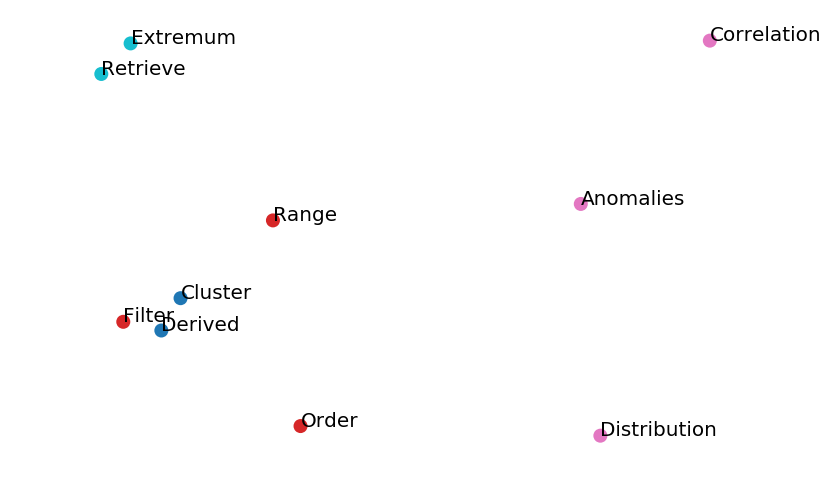

In [29]:
plt.scatter(x0, x1, c=model.labels_, cmap=plt.cm.tab10)
for i, txt in enumerate(task_names):
    plt.annotate(txt, (x0[i],x1[i]))
plt.axis('off')
plt